In [1]:
from gamutrf.detection import *
from tqdm import tqdm

In [2]:
# ARG PARSE PARAMETERS
sample_dir = "/home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/"
nfft = 1024
mini_batch_size = 1024*1024
fft_count = None
save_data = True
skip_inference = True
min_freq = None
max_freq = None



def spectrogram(samples, sample_rate, nfft, noverlap, min_freq=None, max_freq=None, freq_center=None): 
    # Convert samples into spectrogram
    freq_bins, t_bins, spectrogram = signal.spectrogram(
        samples,
        sample_rate,
        window=signal.windows.hann(int(nfft), sym=True),
        nperseg=nfft,
        noverlap=noverlap,
        detrend='constant',
        return_onesided=False,
    )
    # FFT shift 
    freq_bins = np.fft.fftshift(freq_bins)
    spectrogram = np.fft.fftshift(spectrogram, axes=0)
    # Transpose spectrogram
    spectrogram = spectrogram.T
    spectrogram_raw = spectrogram.copy()
    # dB scale spectrogram
    spectrogram = 10 * np.log10(spectrogram)
    
    # Normalize spectrogram
    spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram)) #(spectrogram - db_min) / (db_max - db_min)
    
    spectrogram_data = spectrogram_normalized

    if min_freq is not None and max_freq is not None and freq_center is not None: 
        if fft_count is None: 
            fft_count = len(t_bins)
        spectrogram_data, max_idx, freq_resolution = prepare_custom_spectrogram(
            min_freq, 
            max_freq, 
            sample_rate, 
            nfft, 
            fft_count, 
            noverlap
        )
        idx = np.array(
            [
                round((item - min_freq) / freq_resolution)
                for item in freq_bins + freq_center
            ]
        ).astype(int)
        spectrogram_data[
            : spectrogram_normalized.shape[0],
            idx[np.flatnonzero((idx >= 0) & (idx <= max_idx))],
        ] = spectrogram_normalized[:, np.flatnonzero((idx >= 0) & (idx <= max_idx))]
        
    return spectrogram_data, spectrogram_raw

def spectrogram_cmap(spectrogram_data, cmap): 
    # Spectrogram color transforms 
    #spectrogram_color = cv2.resize(cmap(spectrogram_data)[:,:,:3], dsize=(1640, 640), interpolation=cv2.INTER_CUBIC)[:,:,::-1]
    spectrogram_color = cmap(spectrogram_data)[:,:,:3] # remove alpha dimension
    spectrogram_color = spectrogram_color[::-1,:,:] # flip vertically
    spectrogram_color *= 255
    spectrogram_color = spectrogram_color.astype(int)
    spectrogram_color = np.ascontiguousarray(spectrogram_color, dtype=np.uint8)
    return spectrogram_color

    
if (min_freq is None and max_freq is not None) or (min_freq is not None and max_freq is None): 
    print("Error! If min_freq or max_freq is defined then both must be defined. Exiting.")
    exit()
if min_freq is not None and max_freq is not None: 
    custom_spectrogram = True
else: 
    custom_spectrogram = False

# db_min = -220
# db_max = -60
noverlap = 0 #nfft // 8
model = None
cmap = plt.get_cmap("turbo")

spectrogram_id = 0 
processed_files = []

wait_count = 0 
wait_time = 1
wait_count_limit = 5

while True:
    unprocessed_files = [
        basefilename
        for basefilename in sorted(os.listdir(sample_dir))
        if os.path.isfile(os.path.join(sample_dir, basefilename)) 
        and supported_filetype(basefilename)
        and basefilename not in processed_files
    ]

    # Process files
    if unprocessed_files:

        meta_data = {}

        for basefilename in unprocessed_files: 
            unprocessed_files.remove(basefilename)
            
            # Load samples 
            file_info = parse_filename(os.path.join(sample_dir, basefilename))
            if file_info is None: 
                continue
                
            samples = read_samples(
                file_info["filename"], 
                file_info["sample_dtype"], 
                file_info["sample_len"], 
                seek_bytes=0, 
                nfft=nfft, 
                fft_count=fft_count,
            )
            if samples is None:
                print("Continuing...")
                continue
            processed_files.append(basefilename)
            print(f"Recording duration: {len(samples)/file_info['sample_rate']} seconds")

            # DO BATCHING HERE 
            
            if mini_batch_size is None:
                mini_batch_size = len(samples)
            batch_id = 0
            
            for idx in tqdm(range(0, len(samples), mini_batch_size)): 
                sample_start_idx = idx
                sample_end_idx = idx+mini_batch_size
                sample_batch = samples[sample_start_idx:sample_end_idx]

                print(f"Batch duration: {len(sample_batch)/file_info['sample_rate']} seconds")
                
                spectrogram_data, spectrogram_raw = spectrogram(
                    sample_batch, 
                    file_info["sample_rate"], 
                    nfft, 
                    noverlap, 
                    min_freq=min_freq, 
                    max_freq=max_freq, 
                    freq_center=file_info["freq_center"]
                )
                spectrogram_color = spectrogram_cmap(
                    spectrogram_data, 
                    cmap
                )
    
                
                if save_data or not skip_inference: 

                    batchstr = ""
                    if mini_batch_size != len(samples): 
                        batchstr = f"_batch{batch_id}"
                        
                    savefilename = f"{basefilename}{batchstr}_id{spectrogram_id}"
                    
                    # Save spectrogram as .png
                    if save_data: 
                        spectrogram_img = Image.fromarray(spectrogram_color)
                        image_dir = Path(f"{sample_dir}/png/")
                        image_dir.mkdir(parents=True, exist_ok=True)
                        image_path = image_dir / f"{savefilename}.png"
                        spectrogram_img.save(image_path)
                        meta_data["img_file"] = str(image_path)
                        print("Saved image to "+str(image_path))
            
                    # Run inference model
                    if not skip_inference:
                        if model is None: 
                            model = YOLO("/home/ltindall/ultralytics/runs/detect/yolov8s_exp_v05/weights/best.pt")
                        if spectrogram_id > 0: # bug in yolov8, name parameters is broken in predict()
                            model.predictor.save_dir = Path(f"{sample_dir}/predictions/{savefilename}")
                        results = model.predict(source=spectrogram_color[:,:,::-1], conf=0.05, save=True, save_txt=True, save_conf=True, project=f"{sample_dir}/predictions/", name=f"{savefilename}", exist_ok=True)
        
                    # Save metadata as .json 
                    meta_data["id"] = spectrogram_id
                    file_info["nfft"] = nfft
                    meta_data["sample_file"] = file_info
                    meta_dir = Path(f"{sample_dir}/metadata/")
                    meta_dir.mkdir(parents=True, exist_ok=True)
                    json_object = json.dumps(meta_data, indent=4, cls=DtypeEncoder)
                    meta_data_path = meta_dir / f"{savefilename}.json"
                    with open(meta_data_path, "w") as outfile:
                        outfile.write(json_object)
                    print("Saved metadata to "+str(meta_data_path))
                batch_id += 1
                spectrogram_id += 1    

    else:
        print("Waiting for sample files to process...")
        time.sleep(wait_time)
        wait_count += 1
        if wait_count == wait_count_limit: 
            print(f"No samples found for {wait_time*wait_count_limit} seconds. Exiting.")
            break

Reading /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst
Recording duration: 1.024 seconds


  0%|                                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Batch duration: 0.0512 seconds


  5%|███████▊                                                                                                                                                   | 1/20 [00:00<00:05,  3.73it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch0_id0.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch0_id0.json
Batch duration: 0.0512 seconds


 10%|███████████████▌                                                                                                                                           | 2/20 [00:00<00:04,  4.01it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch1_id1.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch1_id1.json
Batch duration: 0.0512 seconds


 15%|███████████████████████▎                                                                                                                                   | 3/20 [00:00<00:04,  4.11it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch2_id2.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch2_id2.json
Batch duration: 0.0512 seconds


 20%|███████████████████████████████                                                                                                                            | 4/20 [00:00<00:03,  4.17it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch3_id3.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch3_id3.json
Batch duration: 0.0512 seconds


 25%|██████████████████████████████████████▊                                                                                                                    | 5/20 [00:01<00:03,  4.11it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch4_id4.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch4_id4.json
Batch duration: 0.0512 seconds


 30%|██████████████████████████████████████████████▌                                                                                                            | 6/20 [00:01<00:03,  4.16it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch5_id5.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch5_id5.json
Batch duration: 0.0512 seconds


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 7/20 [00:01<00:03,  4.00it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch6_id6.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch6_id6.json
Batch duration: 0.0512 seconds


 40%|██████████████████████████████████████████████████████████████                                                                                             | 8/20 [00:01<00:02,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch7_id7.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch7_id7.json
Batch duration: 0.0512 seconds


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 9/20 [00:02<00:02,  4.14it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch8_id8.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch8_id8.json
Batch duration: 0.0512 seconds


 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 10/20 [00:02<00:02,  4.19it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch9_id9.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch9_id9.json
Batch duration: 0.0512 seconds


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11/20 [00:02<00:02,  4.21it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch10_id10.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch10_id10.json
Batch duration: 0.0512 seconds


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12/20 [00:02<00:01,  4.22it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch11_id11.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch11_id11.json
Batch duration: 0.0512 seconds


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13/20 [00:03<00:01,  4.24it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch12_id12.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch12_id12.json
Batch duration: 0.0512 seconds


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14/20 [00:03<00:01,  4.25it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch13_id13.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch13_id13.json
Batch duration: 0.0512 seconds


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15/20 [00:03<00:01,  4.27it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch14_id14.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch14_id14.json
Batch duration: 0.0512 seconds


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 16/20 [00:03<00:00,  4.27it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch15_id15.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch15_id15.json
Batch duration: 0.0512 seconds


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 17/20 [00:04<00:00,  4.27it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch16_id16.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch16_id16.json
Batch duration: 0.0512 seconds


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 18/20 [00:04<00:00,  4.28it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch17_id17.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch17_id17.json
Batch duration: 0.0512 seconds


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [00:04<00:00,  4.10it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch18_id18.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch18_id18.json
Batch duration: 0.0512 seconds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.16it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch19_id19.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_batch19_id19.json
Reading /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Batch duration: 0.0512 seconds


  5%|███████▊                                                                                                                                                   | 1/20 [00:00<00:04,  3.96it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch0_id20.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch0_id20.json
Batch duration: 0.0512 seconds


 10%|███████████████▌                                                                                                                                           | 2/20 [00:00<00:04,  4.06it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch1_id21.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch1_id21.json
Batch duration: 0.0512 seconds


 15%|███████████████████████▎                                                                                                                                   | 3/20 [00:00<00:04,  4.11it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch2_id22.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch2_id22.json
Batch duration: 0.0512 seconds


 20%|███████████████████████████████                                                                                                                            | 4/20 [00:00<00:03,  4.07it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch3_id23.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch3_id23.json
Batch duration: 0.0512 seconds


 25%|██████████████████████████████████████▊                                                                                                                    | 5/20 [00:01<00:03,  4.05it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch4_id24.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch4_id24.json
Batch duration: 0.0512 seconds


 30%|██████████████████████████████████████████████▌                                                                                                            | 6/20 [00:01<00:03,  3.95it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch5_id25.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch5_id25.json
Batch duration: 0.0512 seconds


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 7/20 [00:01<00:03,  3.86it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch6_id26.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch6_id26.json
Batch duration: 0.0512 seconds


 40%|██████████████████████████████████████████████████████████████                                                                                             | 8/20 [00:02<00:03,  3.91it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch7_id27.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch7_id27.json
Batch duration: 0.0512 seconds


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 9/20 [00:02<00:02,  3.94it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch8_id28.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch8_id28.json
Batch duration: 0.0512 seconds


 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 10/20 [00:02<00:02,  4.01it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch9_id29.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch9_id29.json
Batch duration: 0.0512 seconds


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11/20 [00:02<00:02,  4.03it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch10_id30.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch10_id30.json
Batch duration: 0.0512 seconds


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12/20 [00:02<00:01,  4.05it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch11_id31.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch11_id31.json
Batch duration: 0.0512 seconds


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13/20 [00:03<00:01,  4.07it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch12_id32.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch12_id32.json
Batch duration: 0.0512 seconds


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14/20 [00:03<00:01,  4.06it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch13_id33.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch13_id33.json
Batch duration: 0.0512 seconds


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15/20 [00:03<00:01,  4.06it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch14_id34.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch14_id34.json
Batch duration: 0.0512 seconds


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 16/20 [00:03<00:00,  4.07it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch15_id35.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch15_id35.json
Batch duration: 0.0512 seconds


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 17/20 [00:04<00:00,  4.05it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch16_id36.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch16_id36.json
Batch duration: 0.0512 seconds


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 18/20 [00:04<00:00,  4.03it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch17_id37.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch17_id37.json
Batch duration: 0.0512 seconds


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [00:04<00:00,  4.01it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch18_id38.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch18_id38.json
Batch duration: 0.0512 seconds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.02it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch19_id39.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_batch19_id39.json
Reading /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Batch duration: 0.0512 seconds


  5%|███████▊                                                                                                                                                   | 1/20 [00:00<00:04,  4.12it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch0_id40.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch0_id40.json
Batch duration: 0.0512 seconds


 10%|███████████████▌                                                                                                                                           | 2/20 [00:00<00:04,  3.99it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch1_id41.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch1_id41.json
Batch duration: 0.0512 seconds


 15%|███████████████████████▎                                                                                                                                   | 3/20 [00:00<00:04,  4.07it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch2_id42.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch2_id42.json
Batch duration: 0.0512 seconds


 20%|███████████████████████████████                                                                                                                            | 4/20 [00:00<00:03,  4.01it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch3_id43.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch3_id43.json
Batch duration: 0.0512 seconds


 25%|██████████████████████████████████████▊                                                                                                                    | 5/20 [00:01<00:03,  4.05it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch4_id44.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch4_id44.json
Batch duration: 0.0512 seconds


 30%|██████████████████████████████████████████████▌                                                                                                            | 6/20 [00:01<00:03,  4.11it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch5_id45.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch5_id45.json
Batch duration: 0.0512 seconds


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 7/20 [00:01<00:03,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch6_id46.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch6_id46.json
Batch duration: 0.0512 seconds


 40%|██████████████████████████████████████████████████████████████                                                                                             | 8/20 [00:01<00:02,  4.12it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch7_id47.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch7_id47.json
Batch duration: 0.0512 seconds


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 9/20 [00:02<00:02,  4.15it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch8_id48.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch8_id48.json
Batch duration: 0.0512 seconds


 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 10/20 [00:02<00:02,  4.15it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch9_id49.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch9_id49.json
Batch duration: 0.0512 seconds


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11/20 [00:02<00:02,  4.16it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch10_id50.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch10_id50.json
Batch duration: 0.0512 seconds


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12/20 [00:02<00:01,  4.16it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch11_id51.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch11_id51.json
Batch duration: 0.0512 seconds


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13/20 [00:03<00:01,  4.16it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch12_id52.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch12_id52.json
Batch duration: 0.0512 seconds


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14/20 [00:03<00:01,  4.18it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch13_id53.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch13_id53.json
Batch duration: 0.0512 seconds


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15/20 [00:03<00:01,  4.20it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch14_id54.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch14_id54.json
Batch duration: 0.0512 seconds


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 16/20 [00:03<00:00,  4.18it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch15_id55.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch15_id55.json
Batch duration: 0.0512 seconds


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 17/20 [00:04<00:00,  4.19it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch16_id56.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch16_id56.json
Batch duration: 0.0512 seconds


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 18/20 [00:04<00:00,  4.19it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch17_id57.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch17_id57.json
Batch duration: 0.0512 seconds


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [00:04<00:00,  4.17it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch18_id58.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch18_id58.json
Batch duration: 0.0512 seconds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.14it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch19_id59.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_batch19_id59.json
Reading /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Batch duration: 0.0512 seconds


  5%|███████▊                                                                                                                                                   | 1/20 [00:00<00:04,  4.06it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch0_id60.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch0_id60.json
Batch duration: 0.0512 seconds


 10%|███████████████▌                                                                                                                                           | 2/20 [00:00<00:04,  4.02it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch1_id61.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch1_id61.json
Batch duration: 0.0512 seconds


 15%|███████████████████████▎                                                                                                                                   | 3/20 [00:00<00:04,  3.99it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch2_id62.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch2_id62.json
Batch duration: 0.0512 seconds


 20%|███████████████████████████████                                                                                                                            | 4/20 [00:01<00:04,  3.98it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch3_id63.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch3_id63.json
Batch duration: 0.0512 seconds


 25%|██████████████████████████████████████▊                                                                                                                    | 5/20 [00:01<00:03,  3.98it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch4_id64.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch4_id64.json
Batch duration: 0.0512 seconds


 30%|██████████████████████████████████████████████▌                                                                                                            | 6/20 [00:01<00:03,  3.88it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch5_id65.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch5_id65.json
Batch duration: 0.0512 seconds


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 7/20 [00:01<00:03,  3.85it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch6_id66.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch6_id66.json
Batch duration: 0.0512 seconds


 40%|██████████████████████████████████████████████████████████████                                                                                             | 8/20 [00:02<00:03,  3.89it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch7_id67.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch7_id67.json
Batch duration: 0.0512 seconds


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 9/20 [00:02<00:02,  3.95it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch8_id68.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch8_id68.json
Batch duration: 0.0512 seconds


 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 10/20 [00:02<00:02,  3.98it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch9_id69.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch9_id69.json
Batch duration: 0.0512 seconds


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11/20 [00:02<00:02,  4.01it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch10_id70.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch10_id70.json
Batch duration: 0.0512 seconds


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12/20 [00:03<00:02,  3.84it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch11_id71.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch11_id71.json
Batch duration: 0.0512 seconds


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13/20 [00:03<00:01,  3.89it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch12_id72.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch12_id72.json
Batch duration: 0.0512 seconds


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14/20 [00:03<00:01,  3.95it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch13_id73.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch13_id73.json
Batch duration: 0.0512 seconds


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15/20 [00:03<00:01,  3.99it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch14_id74.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch14_id74.json
Batch duration: 0.0512 seconds


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 16/20 [00:04<00:00,  4.03it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch15_id75.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch15_id75.json
Batch duration: 0.0512 seconds


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 17/20 [00:04<00:00,  4.03it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch16_id76.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch16_id76.json
Batch duration: 0.0512 seconds


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 18/20 [00:04<00:00,  4.02it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch17_id77.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch17_id77.json
Batch duration: 0.0512 seconds


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [00:04<00:00,  4.03it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch18_id78.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch18_id78.json
Batch duration: 0.0512 seconds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.97it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch19_id79.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_batch19_id79.json
Reading /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Batch duration: 0.0512 seconds


  5%|███████▊                                                                                                                                                   | 1/20 [00:00<00:04,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch0_id80.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch0_id80.json
Batch duration: 0.0512 seconds


 10%|███████████████▌                                                                                                                                           | 2/20 [00:00<00:04,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch1_id81.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch1_id81.json
Batch duration: 0.0512 seconds


 15%|███████████████████████▎                                                                                                                                   | 3/20 [00:00<00:04,  4.07it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch2_id82.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch2_id82.json
Batch duration: 0.0512 seconds


 20%|███████████████████████████████                                                                                                                            | 4/20 [00:00<00:03,  4.03it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch3_id83.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch3_id83.json
Batch duration: 0.0512 seconds


 25%|██████████████████████████████████████▊                                                                                                                    | 5/20 [00:01<00:03,  3.96it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch4_id84.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch4_id84.json
Batch duration: 0.0512 seconds


 30%|██████████████████████████████████████████████▌                                                                                                            | 6/20 [00:01<00:03,  3.99it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch5_id85.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch5_id85.json
Batch duration: 0.0512 seconds


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 7/20 [00:01<00:03,  4.03it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch6_id86.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch6_id86.json
Batch duration: 0.0512 seconds


 40%|██████████████████████████████████████████████████████████████                                                                                             | 8/20 [00:01<00:02,  4.10it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch7_id87.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch7_id87.json
Batch duration: 0.0512 seconds


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 9/20 [00:02<00:02,  4.11it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch8_id88.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch8_id88.json
Batch duration: 0.0512 seconds


 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 10/20 [00:02<00:02,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch9_id89.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch9_id89.json
Batch duration: 0.0512 seconds


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11/20 [00:02<00:02,  4.05it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch10_id90.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch10_id90.json
Batch duration: 0.0512 seconds


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12/20 [00:02<00:01,  4.05it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch11_id91.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch11_id91.json
Batch duration: 0.0512 seconds


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13/20 [00:03<00:01,  4.02it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch12_id92.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch12_id92.json
Batch duration: 0.0512 seconds


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14/20 [00:03<00:01,  4.06it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch13_id93.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch13_id93.json
Batch duration: 0.0512 seconds


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15/20 [00:03<00:01,  4.07it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch14_id94.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch14_id94.json
Batch duration: 0.0512 seconds


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 16/20 [00:03<00:00,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch15_id95.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch15_id95.json
Batch duration: 0.0512 seconds


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 17/20 [00:04<00:00,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch16_id96.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch16_id96.json
Batch duration: 0.0512 seconds


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 18/20 [00:04<00:00,  4.09it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch17_id97.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch17_id97.json
Batch duration: 0.0512 seconds


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [00:04<00:00,  4.08it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch18_id98.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch18_id98.json
Batch duration: 0.0512 seconds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.07it/s]

Saved image to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch19_id99.png
Saved metadata to /home/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_batch19_id99.json
Waiting for sample files to process...


Waiting for sample files to process...
Waiting for sample files to process...
Waiting for sample files to process...
Waiting for sample files to process...
No samples found for 5 seconds. Exiting.


In [3]:
print(f"Generated {spectrogram_id} spectrograms from {len(processed_files)} recordings.")

Generated 100 spectrograms from 5 recordings.


In [4]:
unprocessed_files

[]

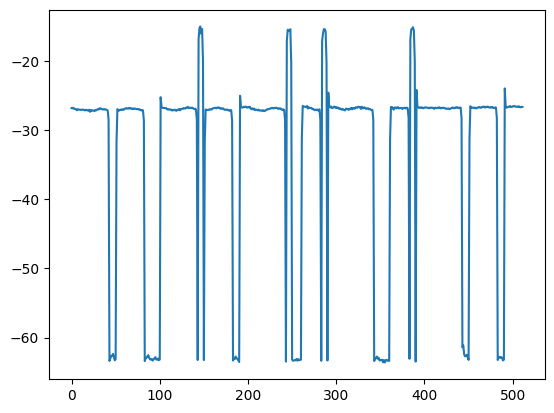

In [5]:
mini_batch = 2048
dbs = []
for idx in range(0, len(sample_batch), mini_batch): 
    a = np.mean(np.abs(sample_batch[idx:idx+mini_batch]/32768)**2)
    a = 10 * np.log10(a)
    dbs.append(a)

plt.figure()
plt.plot(dbs)
plt.show()

In [6]:
import seaborn as sns

/tmp/ipykernel_2684751/3003091721.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dbs, hist = False, kde = True)


<Axes: ylabel='Density'>

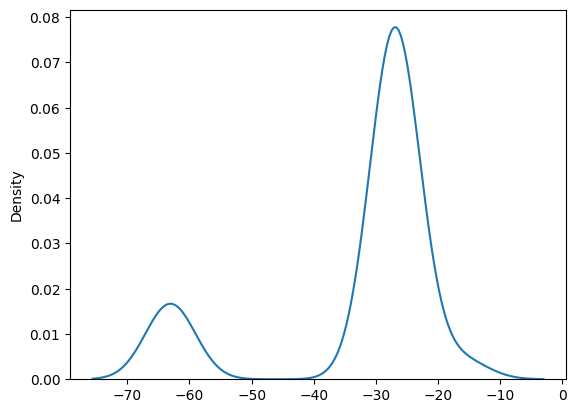

In [7]:
sns.distplot(dbs, hist = False, kde = True)
    

<Axes: ylabel='Count'>

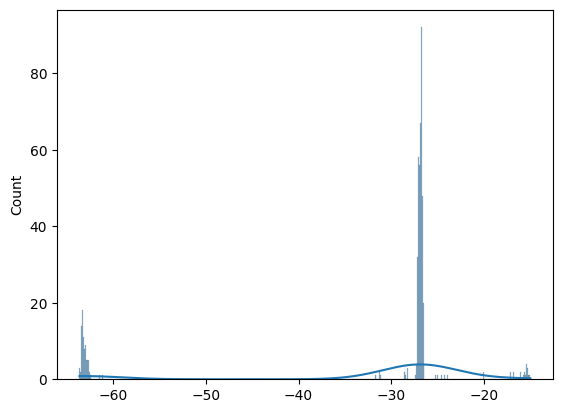

In [8]:
sns.histplot(dbs, kde=True)

In [9]:
spectrogram_color.shape

(1024, 1024, 3)

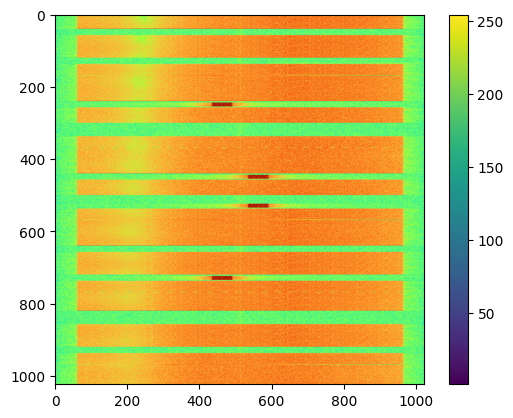

In [10]:
plt.figure()
plt.imshow(spectrogram_color)
plt.colorbar()
plt.show()

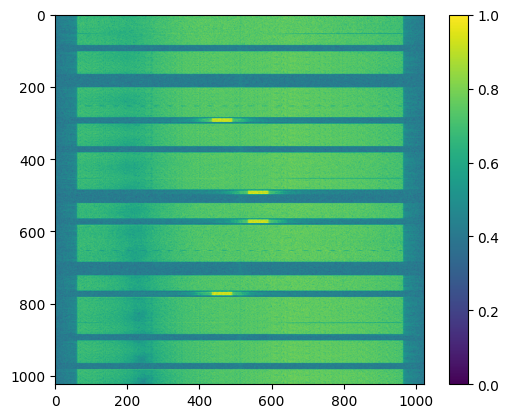

In [11]:
plt.figure()
plt.imshow(spectrogram_data)
plt.colorbar()
plt.show()

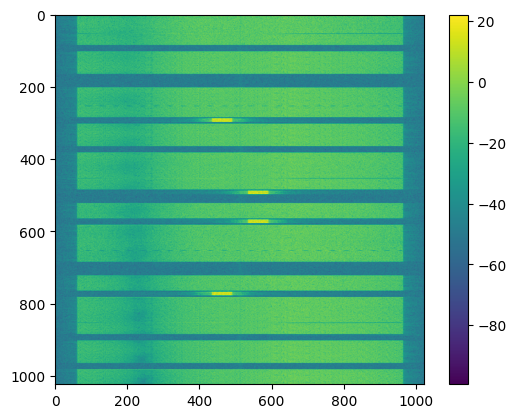

In [12]:
plt.figure()
plt.imshow(10*np.log10(spectrogram_raw))
plt.colorbar()
plt.show()

In [13]:
np.min(spectrogram_raw)

1.14360424e-10

In [14]:
spectrogram_raw.shape

(1024, 1024)

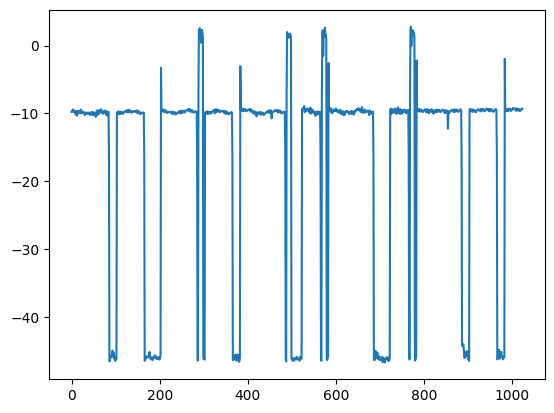

In [15]:
plt.figure()
plt.plot(10*np.log10(np.mean(spectrogram_raw, axis=1)))
plt.show()


In [16]:
np.max(np.mean(spectrogram_raw, axis=1))

1.9151754

In [17]:
512*2048

1048576

In [18]:
1024*1024

1048576